In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE

In [2]:
training_data = pd.read_csv('/kaggle/input/mekong-training-testing-set/merged_train.csv')
testing_data = pd.read_csv('/kaggle/input/mekong-training-testing-set/merged_test.csv')

In [3]:
# Change the type into date time
def into_datetime(df):
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

In [4]:
into_datetime(training_data)
into_datetime(testing_data)

In [5]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 37 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   AWEInsh    223 non-null    float64       
 1   AWEIsh     223 non-null    float64       
 2   MNDWI      223 non-null    float64       
 3   NDWI       223 non-null    float64       
 4   SR_B1      223 non-null    float64       
 5   SR_B2      223 non-null    float64       
 6   SR_B3      223 non-null    float64       
 7   SR_B4      223 non-null    float64       
 8   SR_B5      223 non-null    float64       
 9   SR_B7      223 non-null    float64       
 10  WI1        223 non-null    float64       
 11  WI2        223 non-null    float64       
 12  date       223 non-null    datetime64[ns]
 13  pivot      223 non-null    int64         
 14  reducer    223 non-null    object        
 15  source     223 non-null    object        
 16  Station    223 non-null    object        
 1

In [6]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 37 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   AWEInsh    35 non-null     float64       
 1   AWEIsh     35 non-null     float64       
 2   MNDWI      35 non-null     float64       
 3   NDWI       35 non-null     float64       
 4   SR_B1      35 non-null     float64       
 5   SR_B2      35 non-null     float64       
 6   SR_B3      35 non-null     float64       
 7   SR_B4      35 non-null     float64       
 8   SR_B5      35 non-null     float64       
 9   SR_B7      35 non-null     float64       
 10  WI1        35 non-null     float64       
 11  WI2        35 non-null     float64       
 12  date       35 non-null     datetime64[ns]
 13  pivot      35 non-null     int64         
 14  reducer    35 non-null     object        
 15  source     35 non-null     object        
 16  Station    35 non-null     object        
 17 

In [7]:
features = [ 'SR_B5', 'SR_B7',  'Latitude', 'Longitude', 
            'AWEInsh', 'AWEIsh', 'MNDWI', 'NDWI', 'SR_B1', 
            'SR_B4', 'WI1', 'WI2', 'year', 'month']

In [8]:
target = 'max'

In [9]:
# Split data
X_train = training_data[features]
y_train = training_data[target]
X_test = testing_data[features]
y_test = testing_data[target]

In [10]:
# Define model
model = RandomForestRegressor(random_state=42)

In [11]:
# Apply RFE
rfe = RFE(estimator=model, n_features_to_select=10)  # Choose number of features
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

In [12]:
selected_features = X_train.columns[rfe.get_support()].tolist()
selected_features

['SR_B5',
 'SR_B7',
 'Latitude',
 'Longitude',
 'AWEInsh',
 'AWEIsh',
 'MNDWI',
 'NDWI',
 'SR_B1',
 'year']

In [13]:
param_grid = {
    'n_estimators': [300,500],
    'max_depth': [2,3],                         # Extremely shallow
    'min_child_weight': [3,5,7],             # Avoid small leaves
    'learning_rate': [0.02, 0.03],
    'subsample': [0.5, 0.6],
    'colsample_bytree': [0.6, 0.7],
    'reg_alpha': [7,10],                    # Strong L1
    'reg_lambda': [15,20],                   # Strong L2
    'gamma': [0.3, 0.4]                       # Force minimum gain to split
}

In [14]:
# Initialize model
#xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

In [15]:
grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

In [16]:
grid_search.fit(
    X_train_rfe, y_train,
    eval_set=[(X_test_rfe, y_test)],
    early_stopping_rounds=10,
    verbose=False
)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se

[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se

[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se

[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alp

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=7, n_estimators=300, reg_alp

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=1

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alp

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_al

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=3, n_estimators=300, reg_alp

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=500, reg_al

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alp

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=1

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alph

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=5, n_estimators=300, reg_alpha

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_al

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alph

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=500, reg_al

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alph

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=1

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_alpha

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alp

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alph

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=2, min_child_weight=7, n_estimators=300, reg_alpha=

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=500, reg_alph

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alph

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alp

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.03, max_depth=3, min_child_weight=7, n_estimators=500, reg_al

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alph

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=2, min_child_weight=5, n_estimators=500, reg_alph

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alp

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.02, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alph

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alp

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alph

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=300, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=3, n_estimators=500, reg_alpha

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=1

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=20, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alpha=7, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=3, min_child_weight=3, n_estimators=300, reg_alp

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=7, reg_lambda=20, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alpha=10, reg_lambda=15, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.03, max_depth=2, min_child_weight=7, n_estimators=500, reg_alph

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7], 'gamma': [0.3, 0.4],
                         'learning_rate': [0.02, 0.03], 'max_depth': [2, 3],
                         'min_child_weight': [3, 5, 7],
                         'n_estimators': [300, 500], 'reg_alpha': [7, 10],
                         'reg_lambda': [15, 20], 'subsample': [0.5, 0.6]},
             scoring='neg_mean_squared_error', verbose=2)

In [17]:
# Get best model
best_xgb = grid_search.best_estimator_
print("✅ Best parameters:", grid_search.best_params_)

✅ Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.4, 'learning_rate': 0.03, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 10, 'reg_lambda': 15, 'subsample': 0.6}


In [18]:
import joblib

joblib.dump(best_xgb, 'xgb.pkl')

['xgb.pkl']

In [19]:
def wmape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_true - y_pred)) / (np.sum(np.abs(y_true)) + 1e-8)

def evaluate_model(model, X, y, dataset_name=""):
    y_pred = model.predict(X)
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    wmape_score = wmape(y, y_pred)

    print(f"\n📊 Evaluation on {dataset_name} Set:")
    print(f"• RMSE  : {rmse:.4f}")
    print(f"• R²    : {r2:.4f}")
    print(f"• MAE   : {mae:.4f}")
    print(f"• WMAPE : {wmape_score:.2f}%")

In [20]:
# === 1. Predict on Training and Testing Sets ===
y_train_pred = best_xgb.predict(X_train_rfe)
y_test_pred = best_xgb.predict(X_test_rfe)

In [21]:
# Evaluate on both sets
evaluate_model(best_xgb, X_train_rfe, y_train, "Training")



📊 Evaluation on Training Set:
• RMSE  : 3.8452
• R²    : 0.7874
• MAE   : 2.7664
• WMAPE : 25.90%


In [22]:
evaluate_model(best_xgb, X_test_rfe, y_test, "Testing")


📊 Evaluation on Testing Set:
• RMSE  : 3.8854
• R²    : 0.7272
• MAE   : 2.9722
• WMAPE : 40.52%


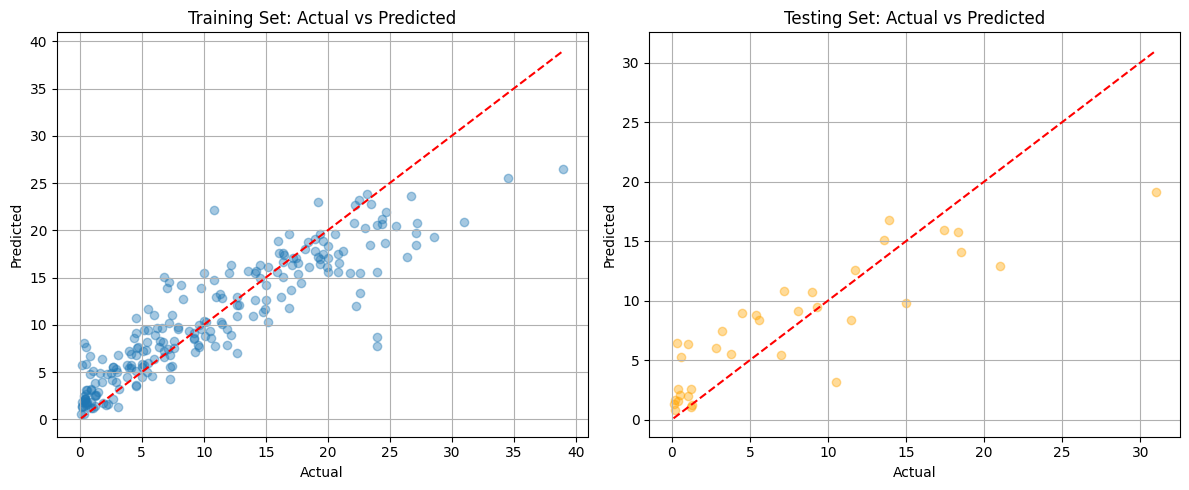

In [23]:
import matplotlib.pyplot as plt
# === 3. Scatter Plot: Actual vs Predicted ===
plt.figure(figsize=(12, 5))

# Training
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.4, label='Train')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Set: Actual vs Predicted')
plt.grid(True)

# Testing
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.4, label='Test', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Set: Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

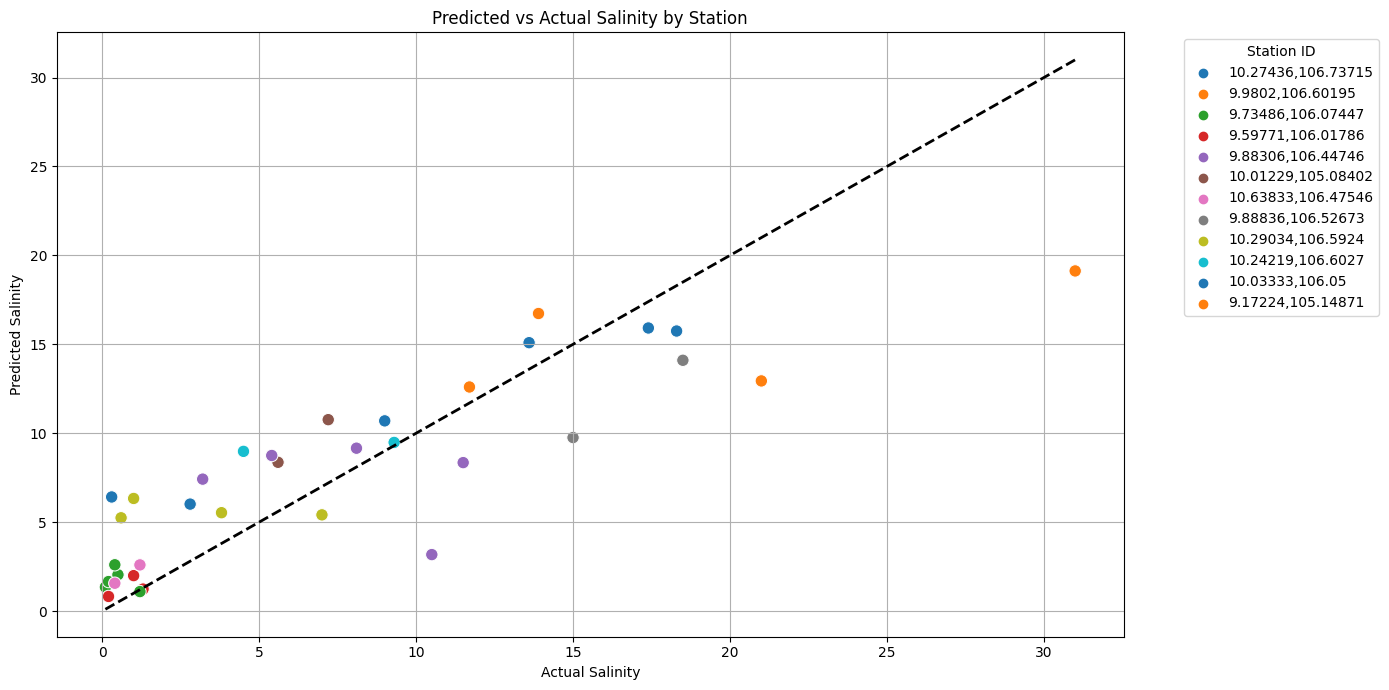

In [24]:

import seaborn as sns

# 1. Predict values for test set
y_pred = best_xgb.predict(X_test_rfe)

# 2. Add predictions and actuals to test DataFrame
plot_df = testing_data.copy()
plot_df['y_pred'] = y_pred
plot_df['y_true'] = y_test.values

# 3. Create a "Station ID" based on coordinates (rounded for grouping)
plot_df['station_id'] = plot_df['Latitude'].round(5).astype(str) + ',' + plot_df['Longitude'].round(5).astype(str)

# 4. Plot predicted vs actual grouped by station
plt.figure(figsize=(14, 7))
sns.scatterplot(data=plot_df, x='y_true', y='y_pred', hue='station_id', palette='tab10', s=80)
plt.plot([plot_df['y_true'].min(), plot_df['y_true'].max()],
         [plot_df['y_true'].min(), plot_df['y_true'].max()], 'k--', lw=2)
plt.xlabel('Actual Salinity')
plt.ylabel('Predicted Salinity')
plt.title('Predicted vs Actual Salinity by Station')
plt.legend(title='Station ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

In [25]:
X_train_selected = X_train[selected_features]

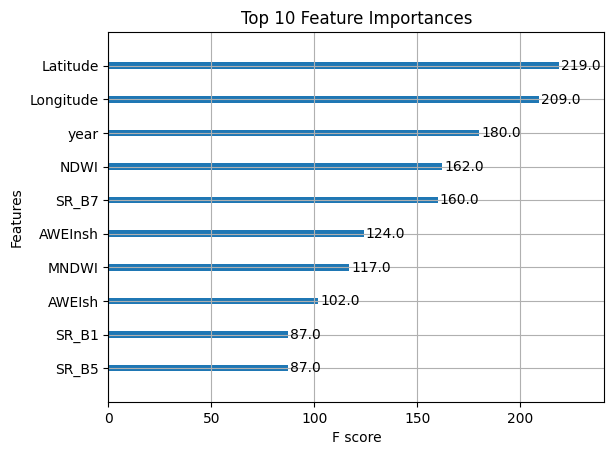

In [26]:
import xgboost as xgb
import matplotlib.pyplot as plt

best_xgb.fit(X_train_selected, y_train)
# Assuming `model` is your trained XGBRegressor or Booster
xgb.plot_importance(best_xgb, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()